* **Grupo 7**
* **Pablo Fernández de Vicente**
* **Antonio Sevillano Martín**

#<center> **Práctica 2 Aprendizaje Automático**

## <center>**Redes de Neuronas Convolucionales**

**Antonio Sevillano y Pablo Fernández, 22-11-2021**
###1. **Introducción**
<p style='text-align: justify;'> En esta práctica se crea un modelo de Red de Neuronas Convolucionales cuyo objetivo es ser capaz de clasificar diferentes imágenes de ropa con sus diferentes tipologías. El modelo va a ser definido, configurado, entrenado, evaluado y mejorado. Posteriormente se realizan predicciones. El modelo se crea en Keras, aplicando el conjunto de datos Fashion-MNIST que contiene 70K imágenes en escala de grises en 10 categorías. Cada imagen muestra una prenda de ropa en baja resolución (28 x 28 píxeles).  </p>



###2. **Desarrollo de los modelos**
<p style='text-align: justify;'> Importamos la librería "numpy" y la llamamos "np". Esta librería nos permite crear vectores y matrices de grandes dimensiones además de poder realizar una gran variedad de funciones matemáticas de alto nivel. También importamos la librería "keras" gracias a la que es posible ejecutar los modelos de Deep Learning. Puede funcionar sobre Theano o TensorFlow. Nosotros en este caso utilizamos el segundo, aseguándonos que la versión es la 2.0.0 o superior. Importamos la librería "matplotlib.pyplot" que nos permite crear y personalizar gráficos en dos dimensiones.  </p>

In [ ]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
#comprobamos la versión de keras
print(tf.keras.__version__)
#comprobamos si hay un GPU disponible para poder ejecutar e modelo
print("GPU Available:", tf.config.list_physical_devices('GPU'))
#comprobamos la versión de TensorFlow
print(tf.__version__)


2.7.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.7.0


Una vez importadas las librerías principales y comprobado que su versión es superior a la 2.0.0 (en este caso 2.7.0), cargamos los datos de entrenamiento y de Test a partir de "keras.datasets.fashion_mnist". La librería contiene un set de 70K imágenes de las cuales 60K son usadas para entrenar la red neuronal y 10K para comprobar qué tan exacto es el modelo. Train_images y Train_labels los utiliza el modelo para aprender. Antes de procesar los datos, comprobamos su dimensión, su forma y el tipo de datos que son. Las imágenes son matrices con una dimensión de 28x28 de enteros de 8 bits (256 valores en escala de grises).


In [ ]:
from keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images.ndim, train_images.shape, train_images.dtype


(3, (60000, 28, 28), dtype('uint8'))

Para hacernos una idea de con qué imágenes vamos a trabajar pintamos con matplotlib una de ellas. En este caso el sexto elemento del tensor.


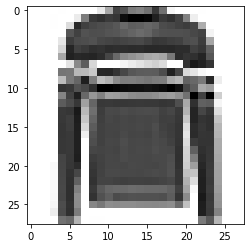

In [ ]:
clothes = train_images[5]
plt.imshow(clothes, cmap=plt.cm.binary)
plt.show()


Cada imagen se corresponde con una etiqueta. Estas etiquetas no se encuentran en el dataset por lo que somos nosotros los que las tenemos que cargar. En este caso las etiquetas se corresponden con la siguiente imagen. Para cargar estas etiquetas basta con crear un array de diez dimensiones en el que la primera posición sea "T-shirt/top", la segunda "Trouser" y así hasta la última.


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
              

3. **Análisis de los datos**
<p style='text-align: justify;'> Antes de comenzar con el entrenamiento del sistema, exploramos el set de datos y comprobamos qué características tiene.
Podemos ver, entre otras cosas, cómo es el set de entrenamiento y cómo es el set de test. </p>
<p style='text-align: justify;'> En la siguiente línea de código se estudia en concreto el set de entrenamiento. Se puede ver que hay 60K imágenes para el entrenamiento y que su dimensión es de 28x28 píxeles.</p>


In [ ]:
train_images.shape


(60000, 28, 28)

Además, el número de etiquetas que hay en este set es de 60K.


In [ ]:
len(train_labels)


60000

Comprobamos que cada etiqueta es un número entero que se encuentra entre el 0 y el 9.


In [ ]:
train_labels


array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

Realizamos el mismo estudio pero con el set de test formado por 10K imágenes.


In [ ]:
test_images.shape


(10000, 28, 28)

Como es lógico, el set de test tendrá el mismo número de etiquetas que de imágenes.


In [ ]:
len(test_labels)


10000

4. **Preprocesado de datos**
<p style='text-align: justify;'> Antes de entrenar el sistema es necesario preprocesar los datos para que se encuentren correctamente para su utilización. </p>
<p style='text-align: justify;'> En primer lugar estudiamos una de las imágenes del set de entrenamiento, por ejemplo la de la posición [5] que hemos comprobado antes. Los valores de los píxeles van a estar entre 0 y 255, que se corresponden con los 256 valores en escala de grises.</p>


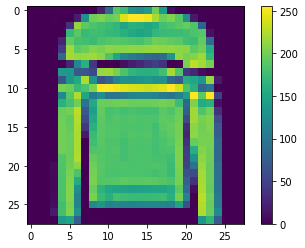

In [ ]:
plt.figure()
plt.imshow(train_images[5])
plt.colorbar()
plt.grid(False)
plt.show()


Dividimos los valores tanto de las imágenes de entrenamiento como de las imágenes de test entre 255 para que sus valores se encuentren en un rango de entre 0 y 1. Además comprobamos las primeras 25 imágenes del set de entrenamiento con su correspondiente etiqueta para comprobar si el set de datos está en el formato adecuado.


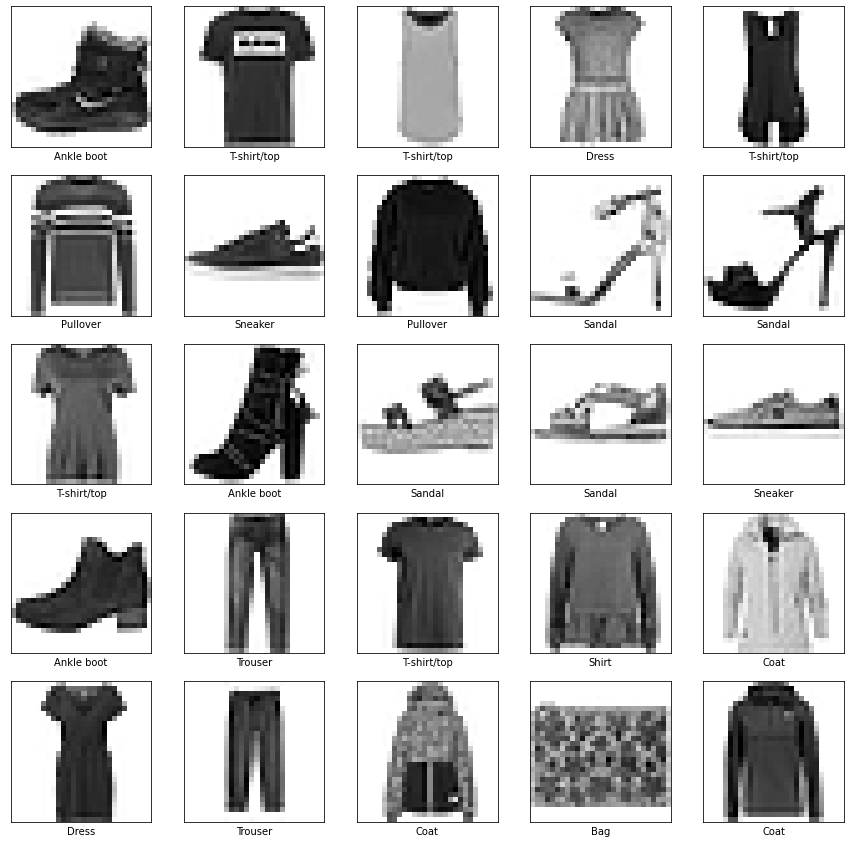

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()


**Construcción de los modelos**
<p style='text-align: justify;'> Para construir la red neuronal hay que configurar las capas del modelo. Utilizamos la función keras.layers.Flatten() que convierte las imágenes en un vector de 784 píxeles (resulta de la multiplicación de 28x28). Esta capa no aprende ningún parámetro, simplemente reformatea el set de datos. Se puede observar como una capa en la misma imagen no apilada de filas de píxeles. </p>

<p style='text-align: justify;'>En todos los modelos utilizamos la función de pérdida "sparse_categorical_crossentropy", la métrica de precisión y 5 épocas. </p>
<p style='text-align: justify;'>Es importante resaltar que la función 
"sparse_categorical_crossentropy" y "categorical_crossentropy" realizan la misma función de pérdida; se utiliza una u otra dependiendo de la forma en que se cargan los datos. La primera funciona con enteros y la segunda con valores one-hot codificados. </p>
<p style='text-align: justify;'>También hay que destacar que cada vez que se ejecuta el programa los resultados obtenidos son algo distintos porque los pesos con los que las neuronas trabajan son aleatorios. Es por esto que al comparar los datos recogidos en la memoria con los datos de la ejecución pueden ser distintos. </p>


Para la construcción de nuestros modelos, vamos a aplicar las **Redes Neuronales Convolucionales (CNN)**. Los conocimientos básicos de las CNN son los siguientes:

*   Las CNN, se usan generalmente para las tareas relacionadas con *Visión por Computador*. 
*   Actualmente, las CNN son muy importantes debido a la importancia de los algoritmos empleados para el *reconocimiento de imagenes*. Por lo tanto se sabe que las entradas son imagenes, es decir, codifica ciertas propieades en la arquitectura para reconocer elementos concretos en las imagenes.
*   Este tipo de Redes de Neuronas funcionan de forma muy similar a como las personas reconocen las imagenes.
*   Las CNN son *clasificadores* que predicen la probabilidad de que aparezca una cierta imagen. Pero antes de poder clasificar dichas imagenes, es necesario reconocer como son los componentes de la imagen.

 




Las **capas** de las Redes de Neuronas Convolucionales:


*   Identifican líneas, bordes, texturas o formas que se asemejen a los componentes de las imagenes.
*   Identifican como se encuentran colocados los componentes entre sí.
*   En una red neuronal convolucional cada capa va aprendiendo 
diferentes niveles de abstracción.



Capas que definen las CNNs:
*   **Capa de Convolución o Convolucional**, la cual aprende patrones locales dentro de la imagen en pequeñas ventanas de 2 dimensiones, también aprenden características o rasgos visuales en las imagenes y por lo tanto, una vez aprendida  una característica en un punto concreto de la imagen la puede reconocer después en cualquier parte. De igual forma, puede aprender jerarquías espaciales de patrones
*   **Capa de Pooling**, la cual se aplica inmediatemente después de las capas convolucionales. Esta capa es la encargada de simplificar o condensar la información recogida por la capa convoluciona, entre las formas de condensar la información se encuentra "max-pooling", la cual se queda con el mayor valor de la ventana establecida.




#### **Modelo 1**

Importamos de la libreria tensorflow.keras, los siguientes elementos: Sequential, Conv2D y MaxPooling2D. Además se establece el modelo como un modelo secuencial.
La red a construir es conocida como **deep**, la cual se conforma mediante el apilamiento de capas.
La red deep que se ha construido esta conformada por dos grupos de capas.

El **primer grupo** de capas esta compuesto por:

*   Una capa Conv2D la cual está conformada por 32 entradas, con un tamaño de ventana de la capa convolucional de 5 x 5. La capa tiene como función de activación "relu", además de un tensor de entrada con formato (28, 28, 1).

*   Una capa MaxPooling2D, en la cual el tamaño de ventana es de 2 x 2.



In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

model1 = Sequential()
model1.add(Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)))
model1.add(MaxPooling2D((2, 2)))
model1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
Total params: 832
Trainable params: 832
Non-trainable params: 0
_________________________________________________________________


El "model.summary()" permite ver cómo es la red neuronal. En este caso la capa Convd2D tiene un output de dimensión (24, 24, 32) puesto que es un tensor 3D. En la sección parámetros marca 832, es decir, el numero de parametro entrenables es 832. En la segunda capa, MaxPooling2D, observamos como esta tiene un output de dimensión (12, 12, 32), con un numero de parametros entrenables igual a 0.

 Siendo así, 832 el numero total de parámetros entrenables en este primer grupo de capas.

El **segundo** **grupo** de capas esta compuesto por:


*   Una capa Conv2D la cual está conformada por 64 entradas o filtros, con un tamaño de ventana de la capa convolucional de 5 x 5. La capa tiene como función de activación "relu".

*   Una capa MaxPooling2D, en la cual el tamaño de ventana es de 2 x 2.



In [ ]:
model1.add(Conv2D(64, (5, 5), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
Total params: 52,096
Trainable params: 52,096
Non-trainable params: 0
_________________________________________________________________


El "model.summary()" permite ver cómo es la red neuronal.

En este segundo grupo de capas, encontramos los parametros entrenables, obtenidos anteriormente en el primer grupo de capas, el cual es igual a 832. 

A estos parámetros, le vamos a añadir una nueva capa Convd2D, la cual tiene un output de dimensión (8, 8, 64) puesto que es un tensor 3D. En la sección parámetros marca 51264, es decir, el numero de parametro entrenables es 51264. Este resultado se obtiene dado que partimos de 12 x 12 en una ventana de 5 x 5 con un stride = 1, por lo tanto el resultado se obtiene de multiplicar la Matriz de Pesos W (5 x 5) por los 32 filtros anteriores por los 64 filtros actuales + 1 del bías, el cual es igual a 64. Es decir, el resultado se obtine de realizar: 5x5x32x64+64.

 En la segunda capa, MaxPooling2D, observamos como esta tiene un output de dimensión (4, 4, 64), con un numero de parametros entrenables igual a 0.

 Siendo así, 52096 el numero total de parámetros entrenables en este segundo grupo de capas.

**Conformamos el Modelo Simple**

Importamos de la libreria tensorflow.keras.layers, los siguientes elementos: Dense, Flatten.
Antes de introducir la capa Dense, introducimos lo capa Flatten, la cual se encarga de ajustar los tensores a la entrada de la capa densa "softmax". Es decir, la capa Flatten se encarga de pasar de un tensor 3D a uno 1D (aplanar).

A continuación introducimos la capa Dense la cual es una capa densamente conectada, con 10 neuronas y que servirá para alimentar una capa final de "softmax".


In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

model1.add(Flatten())
model1.add(Dense(10, activation='softmax'))
model1.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 10)               

El "model.summary()" permite ver cómo es la red neuronal. En este caso la capa Flatten tiene un output de dimensión 1024. No aprende ningún parámetro por lo que en la sección parámetros marca 0. En la segunda capa Dense con función de activación "softmax", indica que se utilizan 10 neuronas y el número de parámetros aprendido es 10250 que es el resultado de multiplicar 1024x10, siendo 1024 el número de parámetros que hay entre [0,...,1023] y 10 el número de neuronas. Finalmente, la capa "softmax" aplica 10 neuronas.


Como se puede observar, el total de parámetros entrenables que es 10250.

Y por lo tanto tras sumar todos los parámetros entrenables de los 3 grupos de capas que hay en el modelo, obtenemos un resultado final de 62346 parámetros entrenables.


 Como es una red convolucional, hay que añadirle una capa para que la convolución funcione, convirtiendo mediante reshape las imagenes en un tensor de tres dimensiones, (ancho, alto, canal).

Como se puede observar a continuación, se lleva a cabo una normalización la cual se realiza para facilitar que converja el proceso de entrenamiento de la red. En general, para alimentar a redes neuronales, no se usan datos con valores que sean mucho más grandes que los valores de los pesos de la red, o datos que sean heterogéneos de rango entre ellos




In [ ]:
from keras.utils.np_utils import to_categorical

mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print (train_images.shape)
print (train_labels.shape)
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print (train_images.shape)
print (train_labels.shape)


(60000, 28, 28)
(60000,)
(60000, 28, 28, 1)
(60000, 10)


**Evaluamos el Sistema**

Para el Modelo1, se emplea la función de perdida "categorical_crossentropy", además empleamos el optimizador "sgd" y por último, empleamos "accuracy" para las métricas. 






In [ ]:
model1.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model1.fit(train_images, train_labels,
          batch_size=100,
          epochs=5,
          verbose=1)

test_loss, test_acc = model1.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

Epoch 1/5
600/600 [==============================] - 6s 8ms/step - loss: 0.8717 - accuracy: 0.7800
Epoch 2/5
600/600 [==============================] - 5s 8ms/step - loss: 0.2544 - accuracy: 0.9261
Epoch 3/5
600/600 [==============================] - 5s 8ms/step - loss: 0.1847 - accuracy: 0.9457
Epoch 4/5
600/600 [==============================] - 5s 8ms/step - loss: 0.1479 - accuracy: 0.9570
Epoch 5/5
313/313 [==============================] - 2s 4ms/step - loss: 0.1073 - accuracy: 0.9683
Test accuracy: 0.9682999849319458


**Gráfico de cómo se comporta el modelo**

A continuación, se lleva a cabo la graficación de los resultads obtenidos con respecto a las imágnes de test. 

Para ello creamos dos funciones, "plot_image" y "plot_value_array" que nos permiten graficar cómo de bien o cómo de mal se comporta el modelo. Estas funciones las vamos a utilizar en los 3 modelos pero con definirlas una única vez es suficiente para poder graficar los diferentes modelos.

In [ ]:
predictions = model1.predict(test_images)
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#00FF00")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('black')

En este caso, miramos la imagen [5], con el vector de sus predicciones y sus predicciones. Las etiquetas correctas se encuentran en negro y las incorrectas en rojo. Se entrega el porcentaje sobre la etiqueta que se está prediciendo.

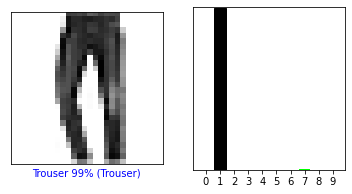

In [ ]:
i = 5
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()


Como podemos observar para esta etiqueta la red no tiene problema alguno para identificarla correctamente.

Ahora procedemos a comprobarlo para las 14 primeras imagenes.


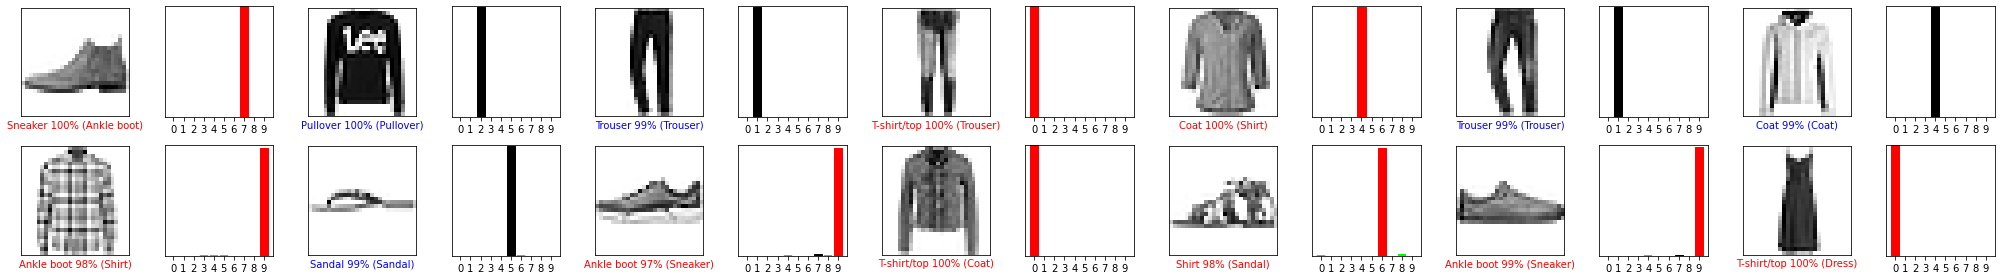

In [ ]:
num_rows = 7
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Observando las catorce primeras imágenes nos damos cuenta de que la red neuronal con los pantalones, las sudaderas, las sandalias y con los abrigos no tiene ningún problema. Con las zapatillas, tan solo detecta correctamente el 5% de ellas, pero generalmente las confunde con botas de tobillo.

Mientras que, el resto de elementos los detecta de forma errónea. Las botas las detecta como zapatillas, las zapatillas las detecta como botas, las camisas las detecta como botas o como abrigos, los abrigos, un tipo de pantalones y los vestidos los detecta como camisetas y las sandalias las detecta como camisas.

Por lo tanto, como se puede observar que hay bastantes etiquetas que tienen mas errores que aciertos. Estos resultados, indican que las imágenes que ya conoce la red neuronal las domina perfectamente. Sin embargo, con las imágenes que no ha visto nunca se pueden observar los abundantes errores y confusiones que experimenta la red neuronal en ciertas etiquetas.

#### **Modelo 2**

El **primer grupo** de capas esta compuesto por:

Una capa Conv2D la cual está conformada por 64 entradas, con un tamaño de ventana de la capa convolucional de 7 x 7. La capa tiene como función de activación "relu", además de un tensor de entrada con formato (28, 28, 1). En esta capa añadimos la función padding = "same", la cual se encarga de rellenar de 0s alrededor de la imagen.

Una capa MaxPooling2D, en la cual el tamaño de ventana es de 2 x 2.

El **segundo grupo** de capas esta compuesto por:

Una capa Conv2D la cual está conformada por 128 entradas o filtros, con un tamaño de ventana de la capa convolucional de 3 x 3. La capa tiene como función de activación "relu", y un padding = "same".

Una capa MaxPooling2D, en la cual el tamaño de ventana es de 2 x 2.

El **tercer grupo** de capas esta compuesto por:

introducimos lo capa Flatten, la cual se encarga de ajustar los tensores a la entrada de la capa densa "softmax". Es decir, la capa Flatten se encarga de pasar de un tensor 3D a uno 1D (aplanar).

A continuación introducimos dos capas Dense. 

La primera capa Dense, la cual es una capa densamente conectada, con 65 neuronas y que servirá para alimentar una capa final de "relu".

La segunda capa Dense, la cual es una capa densamente conectada, con 10 neuronas y que servirá para alimentar una capa final de "softmax".

In [ ]:
model2 = Sequential()
model2.add(Conv2D(64, (7, 7), activation='relu', padding='same', input_shape=(28, 28, 1)))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(65, activation='relu'))
model2.add(Dense(10, activation='softmax'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 65)               

Para el Modelo2, se emplea la función de perdida "categorical_crossentropy", además empleamos el optimizador "sgd" y por último, empleamos "accuracy" para las métricas.

Como es una red convolucional, hay que añadirle una capa para que la convolución funcione, convirtiendo mediante reshape las imagenes en un tensor de tres dimensiones, (ancho, alto, canal).

Como se puede observar a continuación, se lleva a cabo una normalización la cual se realiza para facilitar que converja el proceso de entrenamiento de la red. En general, para alimentar a redes neuronales, no se usan datos con valores que sean mucho más grandes que los valores de los pesos de la red, o datos que sean heterogéneos de rango entre ellos

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
model2.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model2.fit(train_images, train_labels,
          batch_size=100,
          epochs=5,
          verbose=1)

test_loss, test_acc = model2.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

Epoch 1/5
600/600 [==============================] - 8s 12ms/step - loss: 0.9907 - accuracy: 0.7241
Epoch 2/5
600/600 [==============================] - 7s 12ms/step - loss: 0.2792 - accuracy: 0.9174
Epoch 3/5
600/600 [==============================] - 7s 12ms/step - loss: 0.1911 - accuracy: 0.9426
Epoch 4/5
600/600 [==============================] - 7s 12ms/step - loss: 0.1439 - accuracy: 0.9578
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 0.0929 - accuracy: 0.9729
Test accuracy: 0.9728999733924866


**Gráfico de cómo se comporta el modelo**

A continuación, se lleva a cabo la graficación de los resultads obtenidos con respecto a las imágnes de test.

In [ ]:
predictions = model2.predict(test_images)
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

En este caso, miramos la imagen [5], con el vector de sus predicciones y sus predicciones. Las etiquetas correctas se encuentran en negro y las incorrectas en rojo. Se entrega el porcentaje sobre la etiqueta que se está prediciendo.

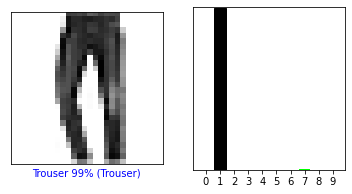

In [ ]:
i = 5
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Como podemos observar para esta etiqueta la red no tiene problema alguno para identificarla correctamente.

Ahora procedemos a comprobarlo para las 14 primeras imagenes.

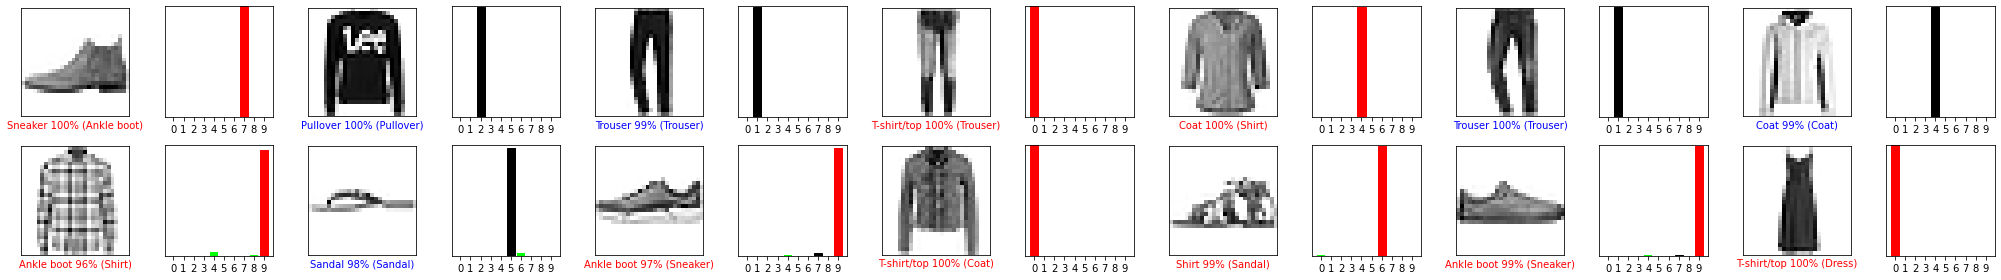

In [ ]:
num_rows = 7
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Observando las catorce primeras imágenes nos damos cuenta de que la red neuronal con los pantalones, las sudaderas, las sandalias y con los abrigos no tiene ningún problema. Con las zapatillas, tan solo detecta correctamente el 2% de ellas, pero generalmente las confunde con botas de tobillo.

Mientras que, el resto de elementos los detecta de forma errónea. Las botas las detecta como zapatillas, las zapatillas las detecta como botas, las camisas las detecta como botas o como abrigos, los abrigos, un tipo de pantalones y los vestidos los detecta como camisetas y las sandalias las detecta como camisas.

Por lo tanto, como se puede observar que hay bastantes etiquetas que tienen mas errores que aciertos. Estos resultados, indican que las imágenes que ya conoce la red neuronal las domina perfectamente. Sin embargo, con las imágenes que no ha visto nunca se pueden observar los abundantes errores y confusiones que experimenta la red neuronal en ciertas etiquetas.

#### **Modelo 3**


El **primer grupo** de capas esta compuesto por:

Una capa Conv2D la cual está conformada por 64 entradas, con un tamaño de ventana de la capa convolucional de 7 x 7. La capa tiene como función de activación "relu", además de un tensor de entrada con formato (28, 28, 1). En esta capa añadimos la función padding = "same", la cual se encarga de rellenar de 0s alrededor de la imagen.

Una capa MaxPooling2D, en la cual el tamaño de ventana es de 2 x 2.

El **segundo grupo** de capas esta compuesto por:

Una capa Conv2D la cual está conformada por 128 entradas o filtros, con un tamaño de ventana de la capa convolucional de 3 x 3. La capa tiene como función de activación "relu", y un padding = "same".

Una capa MaxPooling2D, en la cual el tamaño de ventana es de 2 x 2.

El **tercer grupo** de capas esta compuesto por:

introducimos lo capa Flatten, la cual se encarga de ajustar los tensores a la entrada de la capa densa "softmax". Es decir, la capa Flatten se encarga de pasar de un tensor 3D a uno 1D (aplanar).

A continuación introducimos dos capas Dense.

La primera capa Dense, la cual es una capa densamente conectada, con 65 neuronas y que servirá para alimentar una capa final de "relu".

La segunda capa Dense, la cual es una capa densamente conectada, con 10 neuronas y que servirá para alimentar una capa final de "softmax".

In [ ]:
model3 = Sequential()
model3.add(Conv2D(64, (7, 7), activation='relu', input_shape=(28, 28, 1), padding='same'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Flatten())
model3.add(Dense(65, activation='relu'))
model3.add(Dense(10, activation='softmax'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 6272)              0         
                                                                 
 dense_3 (Dense)             (None, 65)               

Para el Modelo3, se emplea la función de perdida "categorical_crossentropy", además empleamos el optimizador "adam" y por último, empleamos "accuracy" para las métricas.

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model3.fit(train_images, train_labels,
          batch_size=100,
          epochs=5,
          verbose=1)

test_loss, test_acc = model3.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

Epoch 1/5
600/600 [==============================] - 8s 12ms/step - loss: 0.1641 - accuracy: 0.9494
Epoch 2/5
600/600 [==============================] - 7s 12ms/step - loss: 0.0435 - accuracy: 0.9868
Epoch 3/5
600/600 [==============================] - 7s 12ms/step - loss: 0.0314 - accuracy: 0.9901
Epoch 4/5
600/600 [==============================] - 7s 12ms/step - loss: 0.0227 - accuracy: 0.9929
Epoch 5/5
313/313 [==============================] - 2s 5ms/step - loss: 0.0313 - accuracy: 0.9898
Test accuracy: 0.989799976348877


**Gráfico de cómo se comporta el modelo**

A continuación, se lleva a cabo la graficación de los resultads obtenidos con respecto a las imágnes de test.

In [ ]:
predictions = model3.predict(test_images)
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

En este caso, miramos la imagen [5], con el vector de sus predicciones y sus predicciones. Las etiquetas correctas se encuentran en negro y las incorrectas en rojo. Se entrega el porcentaje sobre la etiqueta que se está prediciendo.

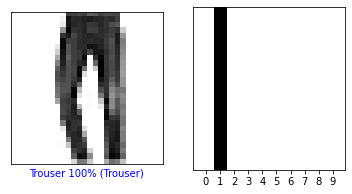

In [ ]:
i = 5
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Como podemos observar para esta etiqueta la red no tiene problema alguno para identificarla correctamente.

Ahora procedemos a comprobarlo para las 14 primeras imagenes.

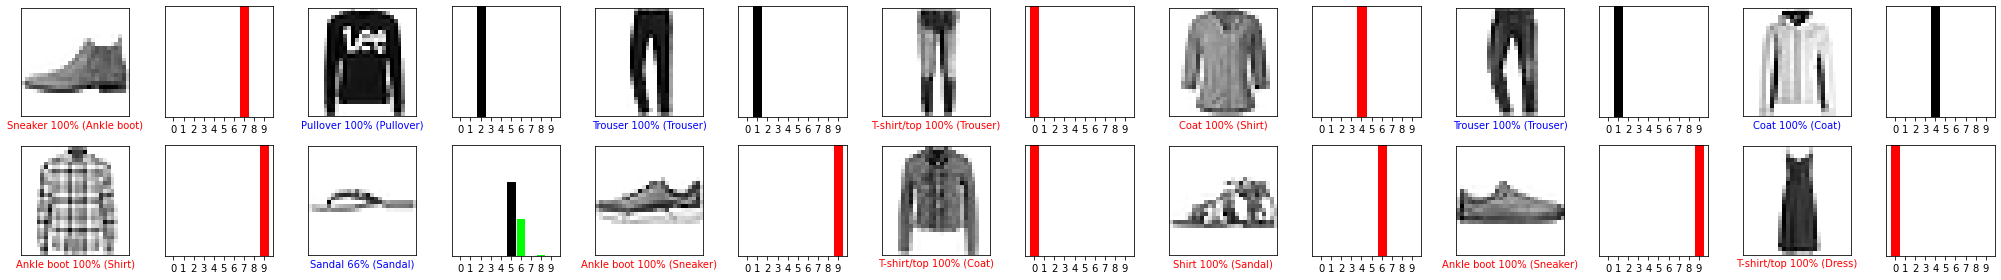

In [ ]:
num_rows = 7
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Observando las catorce primeras imágenes nos damos cuenta de que la red neuronal con los pantalones, las sudaderas y con los abrigos no tiene ningún problema, tan solo con las sandalias encuentra un mayor problema a la hora de identificarlas, experimentando una cierta confusión con las camisas.

Mientras que, el resto de elementos los detecta de forma errónea. Las botas las detecta como zapatillas, las zapatillas las detecta como botas, las camisas las detecta como botas o como abrigos, los abrigos, un tipo de pantalones y los vestidos los detecta como camisetas y las sandalias las detecta como camisas.

Por lo tanto, como se puede observar que hay bastantes etiquetas que tienen mas errores que aciertos. Estos resultados, indican que las imágenes que ya conoce la red neuronal las domina perfectamente. Sin embargo, con las imágenes que no ha visto nunca se pueden observar los abundantes errores y confusiones que experimenta la red neuronal en ciertas etiquetas.

###**Comparación de los mismos modelos con 25 iteraciones**




####   **Modelo 1**




In [ ]:
model1compare = Sequential()
model1compare.add(Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)))
model1compare.add(MaxPooling2D((2, 2)))
model1compare.add(Conv2D(64, (5, 5), activation='relu'))
model1compare.add(MaxPooling2D((2, 2)))
model1compare.add(Flatten())
model1compare.add(Dense(10, activation='softmax'))
model1compare.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model1compare.fit(train_images, train_labels,
          batch_size=100,
          epochs=25,
          verbose=1)

test_loss, test_acc = model1compare.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)


Epoch 1/25
600/600 [==============================] - 5s 8ms/step - loss: 0.9017 - accuracy: 0.7770
Epoch 2/25
600/600 [==============================] - 5s 8ms/step - loss: 0.2652 - accuracy: 0.9220
Epoch 3/25
600/600 [==============================] - 5s 8ms/step - loss: 0.1919 - accuracy: 0.9442
Epoch 4/25
600/600 [==============================] - 5s 8ms/step - loss: 0.1543 - accuracy: 0.9547
Epoch 5/25
600/600 [==============================] - 5s 8ms/step - loss: 0.1305 - accuracy: 0.9617
Epoch 6/25
600/600 [==============================] - 5s 8ms/step - loss: 0.1148 - accuracy: 0.9670
Epoch 7/25
600/600 [==============================] - 5s 8ms/step - loss: 0.1026 - accuracy: 0.9700
Epoch 8/25
600/600 [==============================] - 5s 8ms/step - loss: 0.0945 - accuracy: 0.9719
Epoch 9/25
600/600 [==============================] - 5s 8ms/step - loss: 0.0869 - accuracy: 0.9741
Epoch 10/25
600/600 [==============================] - 5s 8ms/step - loss: 0.0815 - accuracy: 0.9758

El Modelo 1, el cual tenía como función de activación "Relu" y optimizador "sgd", observamos como su precisión es de 0.99 y su función de pérdida es de 0.04.



####   **Modelo 2**




In [ ]:
model2compare = Sequential()
model2compare.add(Conv2D(64, (7, 7), activation='relu', padding='same', input_shape=(28, 28, 1)))
model2compare.add(MaxPooling2D((2, 2)))
model2compare.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model2compare.add(MaxPooling2D((2, 2)))
model2compare.add(Flatten())
model2compare.add(Dense(65, activation='relu'))
model2compare.add(Dense(10, activation='softmax'))
model2compare.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model2compare.fit(train_images, train_labels,
          batch_size=100,
          epochs=25,
          verbose=1)

test_loss, test_acc = model2compare.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

Epoch 1/25
600/600 [==============================] - 8s 12ms/step - loss: 0.9561 - accuracy: 0.7189
Epoch 2/25
600/600 [==============================] - 7s 12ms/step - loss: 0.2750 - accuracy: 0.9172
Epoch 3/25
600/600 [==============================] - 7s 12ms/step - loss: 0.1917 - accuracy: 0.9430
Epoch 4/25
600/600 [==============================] - 7s 12ms/step - loss: 0.1451 - accuracy: 0.9578
Epoch 5/25
600/600 [==============================] - 7s 12ms/step - loss: 0.1159 - accuracy: 0.9657
Epoch 6/25
600/600 [==============================] - 7s 12ms/step - loss: 0.0988 - accuracy: 0.9713
Epoch 7/25
600/600 [==============================] - 7s 12ms/step - loss: 0.0860 - accuracy: 0.9743
Epoch 8/25
600/600 [==============================] - 7s 12ms/step - loss: 0.0781 - accuracy: 0.9766
Epoch 9/25
600/600 [==============================] - 7s 12ms/step - loss: 0.0719 - accuracy: 0.9786
Epoch 10/25
600/600 [==============================] - 7s 12ms/step - loss: 0.0665 - accura

El Modelo 1, el cual tenía como función de activación "Relu" y optimizador "sgd", observamos como su precisión es de 0.99 y su función de pérdida es de 0.03.



####   **Modelo 3**



In [ ]:
model3compare = Sequential()
model3compare.add(Conv2D(64, (7, 7), activation='relu', input_shape=(28, 28, 1), padding='same'))
model3compare.add(MaxPooling2D((2, 2)))
model3compare.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model3compare.add(MaxPooling2D((2, 2)))
model3compare.add(Flatten())
model3compare.add(Dense(65, activation='relu'))
model3compare.add(Dense(10, activation='softmax'))
model3compare.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model3compare.fit(train_images, train_labels,
          batch_size=100,
          epochs=25,
          verbose=1)

test_loss, test_acc = model3compare.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

Epoch 1/25
600/600 [==============================] - 8s 13ms/step - loss: 0.1538 - accuracy: 0.9546
Epoch 2/25
600/600 [==============================] - 7s 12ms/step - loss: 0.0462 - accuracy: 0.9859
Epoch 3/25
600/600 [==============================] - 7s 12ms/step - loss: 0.0318 - accuracy: 0.9899
Epoch 4/25
600/600 [==============================] - 7s 12ms/step - loss: 0.0246 - accuracy: 0.9926
Epoch 5/25
600/600 [==============================] - 7s 12ms/step - loss: 0.0182 - accuracy: 0.9942
Epoch 6/25
600/600 [==============================] - 7s 12ms/step - loss: 0.0140 - accuracy: 0.9955
Epoch 7/25
600/600 [==============================] - 7s 12ms/step - loss: 0.0124 - accuracy: 0.9959
Epoch 8/25
600/600 [==============================] - 7s 12ms/step - loss: 0.0103 - accuracy: 0.9966
Epoch 9/25
600/600 [==============================] - 7s 12ms/step - loss: 0.0097 - accuracy: 0.9967
Epoch 10/25
600/600 [==============================] - 7s 12ms/step - loss: 0.0066 - accura

El Modelo 3, el cual tenía como función de activación "Relu"y optimizador "adam", observamos como su precisión es de 0.99 y su función de pérdida es de 0.05.

Una vez estudiados los tres modelos a los cuales se les han imlementado 25 iteraciones, se puede observar que los tres modelos tiene unos resultados muy similares tanto en su precisión como en su función de pérdida. Por lo tanto se ha establecido el Modelo 2, como el modelo más eficiente para las 25 iteraciones realizadas.

**Caso 1 utilizando tanh en vez de ReLU**

In [ ]:
model1tan = Sequential()
model1tan.add(Conv2D(32, (5, 5), activation='tanh', input_shape=(28, 28, 1)))
model1tan.add(MaxPooling2D((2, 2)))
model1tan.add(Conv2D(64, (5, 5), activation='tanh'))
model1tan.add(MaxPooling2D((2, 2)))
model1tan.add(Flatten())
model1tan.add(Dense(10, activation='softmax'))
model1tan.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model1tan.fit(train_images, train_labels,
          batch_size=100,
          epochs=5,
          verbose=1)

test_loss, test_acc = model1tan.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

Epoch 1/5
600/600 [==============================] - 5s 7ms/step - loss: 0.9611 - accuracy: 0.7786
Epoch 2/5
600/600 [==============================] - 4s 7ms/step - loss: 0.3341 - accuracy: 0.9089
Epoch 3/5
600/600 [==============================] - 4s 7ms/step - loss: 0.2536 - accuracy: 0.9298
Epoch 4/5
600/600 [==============================] - 4s 7ms/step - loss: 0.2098 - accuracy: 0.9416
Epoch 5/5
313/313 [==============================] - 1s 4ms/step - loss: 0.1541 - accuracy: 0.9553
Test accuracy: 0.955299973487854


Tras observar los resultados en ambos modelos:

El Modelo 1, el cual tenía como función de activación "Relu" observamos como su precisión es de 0.97 y su función de pérdida es de 0.11.

El Caso 1, el cual tenía como función de activación "tanh" observamos como su precisión es de 0.96 y su función de pérdida es de 0.15.

Por lo tanto podemos observar como es más eficiente el modelo empleando la función de activación "Relu", puesto que la precisión es mayor que la del modelo con función de activación "tanh". Además el modelo 1 tiene una función de perdidda inferior a la del modelo con F.A "tanh".

###**Comparativa con los resultados de la primera práctica (capas Dense)**

Una vez realizadas ambas prácticas, se pueden observar claras diferencias, entre ellas encontramos como para los modelos de la primera práctica tan solo se empleaban dos capas Dense, con x neuronas dependiendo del modelo en cuestión. A diferencia de esta segunda práctica donde se emplean además de las dos capas Dense, dos capas Convolucionales, realizando de esta forma un entrenamiento más exahustivo debido al número de filtros que cada imagen está sometida a pasar durante el proceso en cuestión. Puesto que las capas convolucionales transforman los datos de entrada utilizando una operación matemática de convolución, puesto que la capa de pooling reduce progresivamente el tamaño espacial de los datos, obteniendo así lotes más pequeños con los que trabajar. Por lo tanto, se observa que las redes convolucionales son mucho más precisas que las artificiales, alcanzando una precisión mucho mayor. 

###**Batch_normalization y dropout**



El batch normalization es una técnica para entrenar redes neuronales muy profundas, covirtiendolas en redes neuronales artificiales más rápidas y estables. Para ello, estandariza las entradas a una capa para cada mini-lote, esto tiene el efecto de estabilizar el proceso de aprendizaje y reducir drásticamente el número de épocas de entrenamiento necesarias para entrenar redes profundas. En este caso, no sería necesario aplicarla ya que estos modelos ya son de por sí muy superficiales. Además no es necesario reducir el número de épocas que ya es muy pequeño

El dropout es una técnica en la que las neuronas seleccionadas al azar se ignoran durante el entrenamiento. En otras palabras, son abandonadas al azar. Esto significa que su contribución a la activación de las neuronas descendentes se elimina temporalmente en el paso hacia adelante y las actualizaciones de peso no se aplican a la neurona en el paso hacia atrás.

###**Callbacks**
Los callbacks son un conjunto de funciones que se aplican a determinadas etapas del procedimiento de formación de la red. Se pueden utilizar para obtener una vista de los estados internos y las estadísticas del modelo durante el entrenamiento. Permite hacernos una idea de su funcionamiento.
Se utilizan cuando se quieren automatizar algunas tareas después de cada época. Esto ayuda a detener el ayuntamiento cuando alcanza un determinado margen de precisión. Existen varias funciones de llamada. Se pueden destacar "EarlyStopping", "ModelCheckpoint" o "LearningRateScheduler" entre otras.

###**Conclusión**
Después de analizar todos los modelos, es curioso que no identifiquen todas las imágenes como deberían con la precisión tan alta que alcanzan. 
Una posible razón es que la red neuronal se quede atrapada en un mínimo local, lo que impide que alcance el mínimo absoluto. Esto se debe, probablemente al escaso número de iteraciones que realizan los modelos.
La precisión es todavía mas alta que con las redes neuronales artificiales por lo que la posibilidad de que la red se quede atrapada en un mínimo local puede explicar el hecho de que no identifique correctamente todas las imágenes.
Otra posibilidad es que la red confunda las etiquetas del set de entrenamiento con las del set de test de forma que identifica perfectamente las imágenes pero a la hora de hacer el análisis  confunde las etiquetas.
En cualquier caso, se puede observar que las redes convolucionales son mucho más precisas (en el test_accurancy) que las artificiales y alcanzan una precisión mucho mayor. Sobre todo en el análisis de imágenes.